In [1]:

import numpy as np
from glm import BernoulliGLM, BernoulliGLMwReg, BernoulliGLMPyTorch
import pandas as pd
from preprocess_data import *

import torch
import torch.nn as nn
import torch.distributions as dist

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [28]:
sim_data_path = './sim/save/pagsim/'
use_torch = True

all_dfs = []
all_timings = []
all_binned_spikes = []
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]       

# extract all input spikes and bin them
for brain_region in brain_regions:
    df = extract_sim_as_df(sim_data_path, brain_region)
    all_dfs.append(df)
    timings = extract_timings(df, brain_region)
    all_timings.append(timings)

_total_length = np.max([total_length(df) for df in all_dfs])
for i, brain_region in enumerate(brain_regions):
    binned_spikes = (bin_spikes(all_timings[i], start_time=0, end_time=_total_length, bin_size=0.001))
    all_binned_spikes.append(binned_spikes)
    print(f'Average {brain_region} firing rate: {np.sum(binned_spikes) / len(all_timings[i]) / _total_length} Hz.')


pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[0,:][None,:]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / len(pag_timings) / _total_length} Hz.')

X_ones_step = np.vstack(all_binned_spikes)
X = np.repeat(X_ones_step, 1, axis=1) # repeat input timings (n_PAG_neuron) times
y = pag_binned_spikes.swapaxes(0,1).reshape(1,-1) # flatten all pag neurons out to (1, T * n_PAG_neurons)
assert X.shape[1] == y.shape[1]

2023-11-13 18:01:17.054 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 64 neurons and 120000 bins. Total number of spikes: 50535.0
2023-11-13 18:01:17.169 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 64 neurons and 120000 bins. Total number of spikes: 50248.0


Average VMH firing rate: 6.580094575236439 Hz.
Average ACC firing rate: 6.542724690145059 Hz.


2023-11-13 18:01:17.299 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 64 neurons and 120000 bins. Total number of spikes: 50500.0
2023-11-13 18:01:17.452 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 64 neurons and 120000 bins. Total number of spikes: 50480.0


Average IC firing rate: 6.575537272176514 Hz.
Average SC firing rate: 6.572933098999415 Hz.


2023-11-13 18:01:17.585 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 64 neurons and 120000 bins. Total number of spikes: 50296.0
2023-11-13 18:01:17.640 | DEBUG    | preprocess_data:bin_spikes:58 - Created spike bin matrix with 2 neurons and 120000 bins. Total number of spikes: 16012.0


Average PMD firing rate: 6.548974705770099 Hz.
Average PAG firing rate: 36.487591218978054 Hz.


In [29]:
def normalise_array(array):
    if isinstance(array, torch.Tensor):
        array = array.cpu().numpy()
    return (array - np.mean(array)) / np.std(array)

glm = BernoulliGLMPyTorch(
    n_neurons_per_group=np.array([len(df) for df in all_dfs]),
    link_fn='logistic',
    reg_params=0.1,
    ).to(device)

glm.fit(X.T, y.T, n_iter=10000, lr=1e-3, verbose=1)
glm.load_best_params()

2023-11-13 18:01:25.390 | DEBUG    | glm:fit:258 - Training GLM with PyTorch. Initial log like: -84889.3828125, inital loss: tensor([[84889.3828]])
2023-11-13 18:01:29.781 | DEBUG    | glm:fit:276 - Step 500. Log like: -47959.328125,  loss: 47960.1796875
2023-11-13 18:01:34.249 | DEBUG    | glm:fit:276 - Step 1000. Log like: -40257.484375,  loss: 40267.734375
2023-11-13 18:01:38.585 | DEBUG    | glm:fit:276 - Step 1500. Log like: -37064.1796875,  loss: 37107.76171875
2023-11-13 18:01:42.971 | DEBUG    | glm:fit:276 - Step 2000. Log like: -35020.953125,  loss: 35117.69140625
2023-11-13 18:01:47.208 | DEBUG    | glm:fit:276 - Step 2500. Log like: -33465.8984375,  loss: 33603.640625
2023-11-13 18:01:51.445 | DEBUG    | glm:fit:276 - Step 3000. Log like: -32192.9296875,  loss: 32343.212890625
2023-11-13 18:01:55.665 | DEBUG    | glm:fit:276 - Step 3500. Log like: -31145.33203125,  loss: 31291.93359375
2023-11-13 18:01:59.852 | DEBUG    | glm:fit:276 - Step 4000. Log like: -30313.8671875,  

Corr btwn GLM and Syn for VMH:  0.9512266391479438


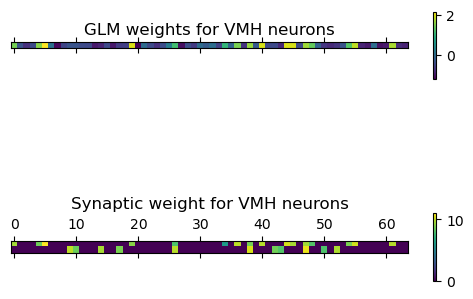

Corr btwn GLM and Syn for ACC:  0.9187075136468477


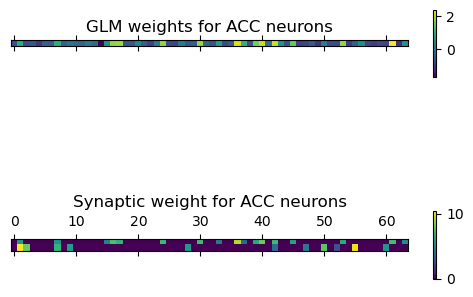

Corr btwn GLM and Syn for IC:  0.9399463398354534


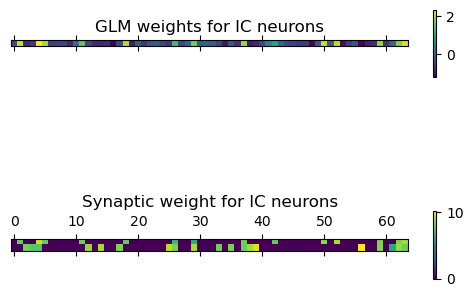

Corr btwn GLM and Syn for SC:  0.921244331172372


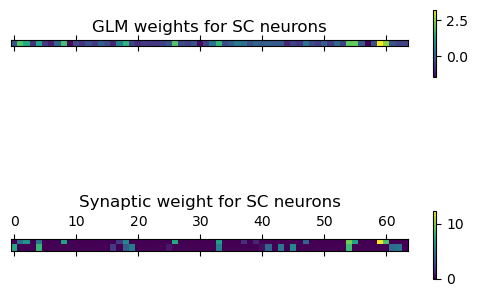

Corr btwn GLM and Syn for PMD:  0.9632927358697331


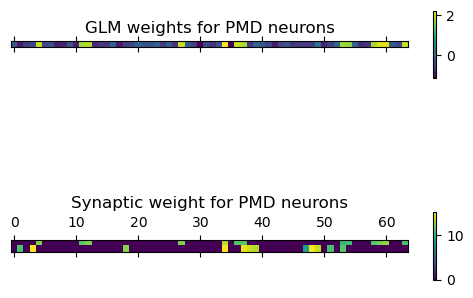

In [30]:
corrs = []
for i, brain_region in enumerate(brain_regions):
    glm_w = glm.best_weight[:,glm.neuron_group_cumsum[i]:glm.neuron_group_cumsum[i+1]].cpu()
    conn = np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0) * 1e9
    
    corr = np.corrcoef(glm_w[0,:], conn[:,0])[0,1]
    corrs.append(corr)
    print(f'Corr btwn GLM and Syn for {brain_region}: ', corr)
    
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True)
    m = axes[0].matshow(normalise_array(glm_w))
    f.colorbar(m, shrink=0.4)
    axes[0].set_title(f'GLM weights for {brain_region} neurons')
    axes[0].set_yticks([])

    m = axes[1].matshow(conn.T)
    f.colorbar(m, shrink=0.4)
    axes[1].set_title(f'Synaptic weight for {brain_region} neurons')
    axes[1].set_yticks([])

    plt.show()

In [35]:
np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy').shape

(64,)

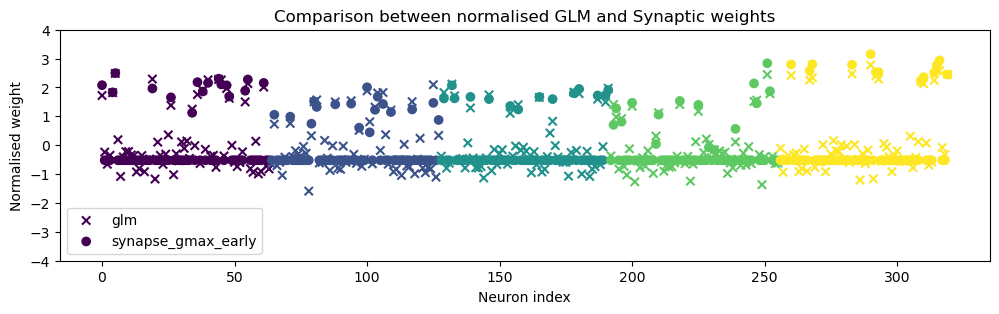

In [36]:
glm_ws = glm.best_weight.cpu()[0,:]
brian2_ws = np.concatenate([np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy')[:,0], nan=0.0) for brain_region in brain_regions])
plt.figure(figsize=(12,3))
plt.scatter(np.arange(320), normalise_array(glm_ws), marker='x', c=glm.neuron_group_idx, label='glm')
plt.scatter(np.arange(320), normalise_array(brian2_ws), marker='o', c=glm.neuron_group_idx, label='synapse_gmax_early')
plt.xlabel('Neuron index')
plt.ylabel('Normalised weight')
plt.ylim([-4,4])
plt.legend(loc='best')
plt.title('Comparison between normalised GLM and Synaptic weights')
plt.savefig('./figs/w_glm_b2_comparison', dpi=350, bbox_inches='tight')
plt.show()

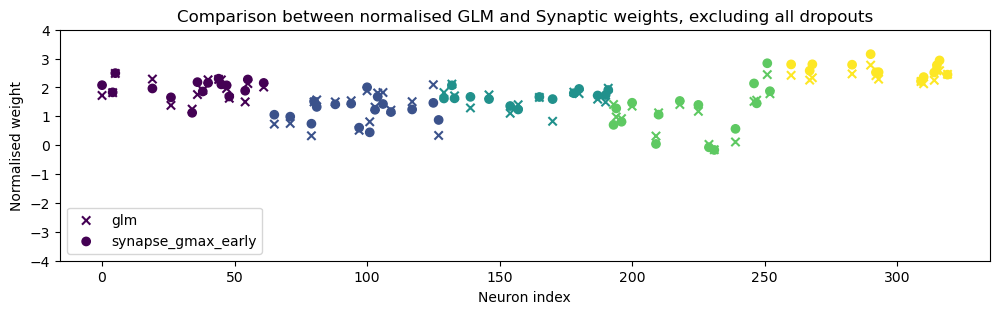

In [37]:
non_zero_idx = np.where(brian2_ws > 0)[0]
plt.figure(figsize=(12,3))
plt.scatter(non_zero_idx, normalise_array(glm_ws)[non_zero_idx], marker='x', c=glm.neuron_group_idx[non_zero_idx], label='glm')
plt.scatter(non_zero_idx, normalise_array(brian2_ws)[non_zero_idx], marker='o', c=glm.neuron_group_idx[non_zero_idx], label='synapse_gmax_early')
plt.xlabel('Neuron index')
plt.ylabel('Normalised weight')
plt.ylim([-4,4])
plt.legend(loc='best')
plt.title('Comparison between normalised GLM and Synaptic weights, excluding all dropouts')
plt.savefig('./figs/w_glm_b2_comparison_non_zero', dpi=350, bbox_inches='tight')
plt.show()

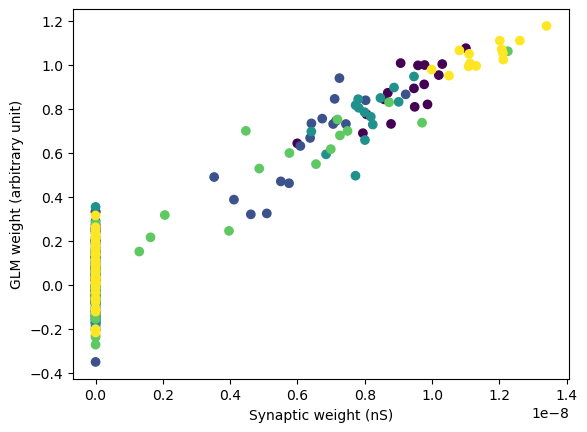

In [38]:
plt.scatter(brian2_ws, glm_ws, c=glm.neuron_group_idx)
plt.xlabel('Synaptic weight (nS)')
plt.ylabel('GLM weight (arbitrary unit)')
plt.show()

In [41]:
glm.best_bias

tensor([-3.1433], device='cuda:0')

In [3]:
reg_params = [0, .001, .005, .01, .05, .1, .5, 1, 5, 10, 50, 100]
corrss = []
for i, reg_param in enumerate(reg_params):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    glm = BernoulliGLMPyTorch(
        n_neurons_per_group=np.array([len(df) for df in all_dfs]),
        link_fn='logistic',
        reg_params=reg_param,
        ).to(device)

    glm.fit(X.T, y.T, n_iter=10000, lr=1e-3, verbose=0)
    # glm.load_best_params()
    
    corrs = []
    for m, brain_region in enumerate(brain_regions):
        glm_w = glm.best_weight[:,glm.neuron_group_cumsum[m]:glm.neuron_group_cumsum[m+1]].cpu()
        conn = np.nan_to_num(np.load(f'./sim/save/pagsim/connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0) * 1e9
        
        corr = np.corrcoef(glm_w[0,:], conn[:,0])[0,1]
        corrs.append(corr)
    print(f'({i+1} / {len(reg_params)}) Testing regularisaiton parameter {reg_param}, correlations: {corrs}')
    corrss.append(corrs)

2023-11-13 14:36:11.822 | DEBUG    | glm:fit:258 - Training GLM with PyTorch. Initial log like: -8534.3359375, inital loss: tensor([[8534.3359]])


KeyboardInterrupt: 

Text(0.5, 1.0, 'Correlation between GLM weights and Brian2 weights')

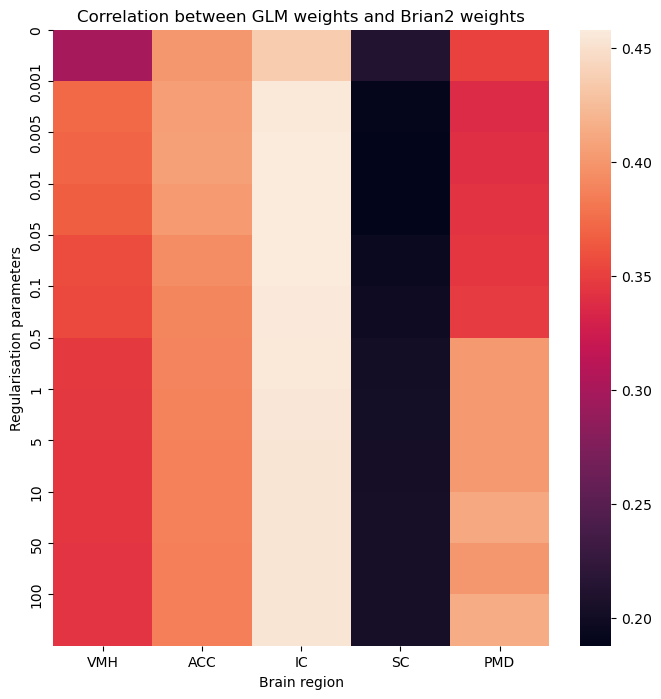

In [15]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(np.array(corrss))
plt.xticks(np.arange(5)+0.5, brain_regions)
plt.xlabel('Brain region')
plt.ylabel('Regularisation parameters')
plt.yticks(np.arange(len(reg_params)), reg_params)
plt.title('Correlation between GLM weights and Brian2 weights')